# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Problem Statement

We would like to build a model to predict whether a user answers an offer or not, to enable users to predict which personas a offer could reach. 

For that, we will train a classifier on features based on properties of the persons and offers in the past to see for which kind of offer which persona is likely to accept it. 

We would expect a model to at least perform better than just guessing not responding or responding for all entries in the test set.

# Metrics

We choose the F1 score as a metric because we are interested in both a high precision and recall to predict both the users accepting an offer and declining an offer as accurate as possible.

In [33]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
% matplotlib inline

In [34]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration
## Portfolio Data

The Portfolio Data contains all kinds of properties for the different offers.

In [35]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [36]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


No Null objects in the dataset, we only need to create dummy variables for both the channels and offer_type columns.

In [37]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


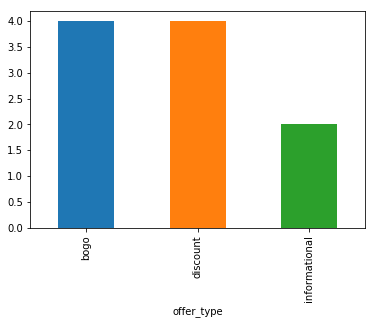

In [38]:
portfolio.groupby('offer_type')['id'].count().plot(kind='bar')

In [39]:
portfolio = pd.concat([portfolio.drop(columns=['offer_type']), pd.get_dummies(portfolio['offer_type'], prefix='type')], axis=1)

In [40]:
portfolio = portfolio.rename(columns={'id': 'offer_id'})

In [41]:
channels = list(set(sum(portfolio['channels'], [])))
channels

['mobile', 'social', 'email', 'web']

In [42]:
def channels_to_dummy(row):
    """
    returns dummy variables for the list of channels in the channels column
    """
    channel_row = row['channels']
    for channel in channels:
        if channel in channel_row:
            row['channel_' + channel] = 1
        else:
            row['channel_' + channel] = 0
    return row
portfolio = portfolio.apply(channels_to_dummy, axis=1)
portfolio

,channels,difficulty,duration,offer_id,reward,type_bogo,type_discount,type_informational,channel_mobile,channel_social,channel_email,channel_web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,0,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,0,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,0,0,1,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,0,1,1


## Profile Data

The Profile Data contains all kinds of properties for the different users.

In [43]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


Only gender and income have null values. However, it later turns out that age is set to a default of 118 if no data is present.

In [44]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Split dataset to check the nan rows and full rows. 

In [45]:
without_demographics = profile[profile['age'] == 118]

In [46]:
without_demographics.shape[0]

2175

In [47]:
without_demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


As expected, all None values in gender and income come hand in hand.

In [22]:
with_demographics = profile[profile['age'] != 118]

In [23]:
with_demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [24]:
with_demographics.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


We bin each user groups into 9 bines based on their income, which makes each bin cover a range of 10000.

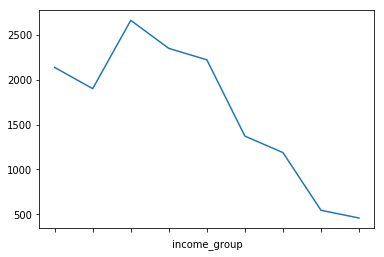

In [49]:
with_demographics.loc[:,'income_group'] = pd.cut(with_demographics.loc[:,'income'],
                              bins=9)
with_demographics.groupby('income_group')['id'].count().plot()

In [51]:
# set default values of 118 to None to make it more clear
profile.loc[profile['age']==118, 'age'] = None

In [52]:
profile = profile.rename(columns={'id': 'person'})

In [29]:
profile['became_member_on'].dtype

dtype('int64')

In [53]:
# add feature of number of days from became member on until today
profile['became_member_on'] = profile['became_member_on'].astype(str)
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])
profile['membership_duration'] = (pd.to_datetime('today') - profile['became_member_on']).dt.days

In [54]:
# add dummy variables for gender
profile = pd.concat([profile.drop(columns=['gender']), pd.get_dummies(profile['gender'], prefix='gender')], axis=1)

## Transcript Data

The Transcript Data contains a log for the activities of users concerning offers.

In [60]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [61]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


No None values to drop.

In [62]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [63]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

We check the transcript for one single person. 

In [64]:
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [65]:
def dict_to_columns(row):
    """
    Returns row with column entries for each entry in the dict in 'value' column
    """
    for key, value in row['value'].items():
        row[key] = value
    return row
transcript = transcript.apply(dict_to_columns, axis=1)
transcript

,amount,event,offer id,offer_id,person,reward,time,value
0,NaN,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,78afa995795e4d85b5d9ceeca43f5fef,NaN,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,NaN,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,NaN,offer received,2906b810c7d4411798c6938adc9daaa5,NaN,e2127556f4f64592b11af22de27a7932,NaN,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,NaN,offer received,fafdcd668e3743c1bb461111dcafc2a4,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,NaN,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,NaN,offer received,f19421c1d4aa40978ebb69ca19b0e20d,NaN,389bc3fa690240e798340f5a15918d5c,NaN,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,NaN,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,c4863c7985cf408faee930f111475da3,NaN,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,NaN,offer received,3f207df678b143eea3cee63160fa8bed,NaN,2eeac8d8feae4a8cad5a6af0499a211d,NaN,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,NaN,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,aa4862eba776480b8bb9c68455b8c2e1,NaN,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,NaN,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,31dda685af34476cad5bc968bdb01c53,NaN,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


The offer id is sometimes called 'offer_id' and sometimes 'offer id' in the dict in the value column. Hence, we move all entries from column 'offer id' also into 'offer_id'. 

In [66]:
transcript.loc[transcript['offer_id'].isna(), 'offer_id'] = transcript.loc[transcript['offer_id'].isna(), 'offer id']
transcript = transcript.drop(columns=['offer id'])
transcript = transcript.drop(columns=['value'])

We build the new offers DataFrame, which contains the offer_id, person and a list of the unique events that belong to this offer and person. As we later want to predict whether a person reacted to an offer, we first add a list of the events that happened with a specific person and offer, and then add a categorical variable whether the user reacted to this offer or not. 

In [67]:
offers = transcript.groupby(['offer_id', 'person']).agg({'event':lambda x: list(x)}).reset_index()

In [68]:
def person_reacted_to_offer(row):
    """
    Returns row with reacted_to_offer column that is 1 if a user viewed and completed an offer, 0 otherwise.
    """
    if set(['offer viewed', 'offer completed']).issubset(row['event']):
        row['reacted_to_offer'] = 1
    else:
        row['reacted_to_offer'] = 0
    return row
offers = offers.apply(person_reacted_to_offer, axis=1)

In [69]:
offers.head()

,offer_id,person,event,reacted_to_offer
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,"[offer received, offer viewed, offer completed]",1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,"[offer received, offer completed]",0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,[offer received],0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,"[offer received, offer completed]",0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,"[offer received, offer viewed]",0


We then merge all 3 dataframes together to add the properties of the offer and the person to the offers Dataframe.

In [70]:
data = offers.merge(profile, on='person', how='left')
data = data.merge(portfolio, on='offer_id', how='left')

In [71]:
data = data.dropna()

In [72]:
data.columns

Index(['offer_id', 'person', 'event', 'reacted_to_offer', 'age',
       'became_member_on', 'income', 'membership_duration', 'gender_F',
       'gender_M', 'gender_O', 'channels', 'difficulty', 'duration', 'reward',
       'type_bogo', 'type_discount', 'type_informational', 'channel_mobile',
       'channel_social', 'channel_email', 'channel_web'],
      dtype='object')

# Training and Comparing models

In [82]:
X = data[['age', 'income', 'membership_duration', 'gender_F', 'gender_M', 'gender_O', 'difficulty', 'duration', 'reward', 'type_bogo', 'type_discount', 'type_informational', 'channel_web', 'channel_social', 'channel_mobile', 'channel_email']]
y = data['reacted_to_offer']

We scale all non-categorical (dummy) variables with the StandardScaler to give each feature an equal influence.

In [84]:
scaler = StandardScaler()
X.loc[:,['age', 'income', 'membership_duration', 'difficulty', 'duration', 'reward']] = scaler.fit_transform(X[['age', 'income', 'membership_duration', 'difficulty', 'duration', 'reward']])

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Percentage of users who reacted to an offer in the test set:

In [86]:
y_test.sum()/len(y_test)

0.42625622453598916

We chose the decision tree of the top answer from this post (https://stackoverflow.com/questions/2595176/which-machine-learning-classifier-to-choose-in-general) as a guideline for which models to try. This led us to try out LinearSVC and KNeighbours Classifier.

In [87]:
svc_clf = LinearSVC()

In [88]:
svc_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [89]:
y_pred_train = svc_clf.predict(X_train)
train_f1 = f1_score(y_train, y_pred_train)
train_f1

0.69780119934581142

In [90]:
y_pred_test = svc_clf.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_f1

0.6999896297832624

Already this default model performs good, as 0.42 of the values are 1 and this f1 score is .69, it is already better than just guessing that all values are 0.

To compare, we also try the KNeighbors Classifier.

In [93]:
clf = KNeighborsClassifier(n_neighbors=5)

In [94]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [95]:
y_pred_train = clf.predict(X_train)
train_f1 = f1_score(y_train, y_pred_train)
train_f1

0.78990747633733904

In [96]:
y_pred_test = clf.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_f1

0.69503395585738537

As the training F1 is so high compared to the test F1, we see overfitting. Hence, we increase n_neighbors to work against it. 

In [97]:
clf = KNeighborsClassifier(n_neighbors=7)

In [98]:
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
train_f1 = f1_score(y_train, y_pred_train)
train_f1

0.77261249767429496

In [99]:
y_pred_test = clf.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_f1

0.70270270270270274

In [100]:
clf = KNeighborsClassifier(n_neighbors=10)

In [101]:
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
train_f1 = f1_score(y_train, y_pred_train)
train_f1

0.74099340361955235

In [102]:
y_pred_test = clf.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_f1

0.689779378658262

n_neighbors=7 seems optimal for the KN Classifier. We also try to improve the LinearSVC using cross-validation to see how well it can become. 

In [103]:
params = {
    'max_iter': [1000, 2000],
    'loss': ['hinge', 'squared_hinge'],
    'C': [1.0, 1.5]
}
f1_scorer = make_scorer(f1_score)
cv = GridSearchCV(svc_clf, params, scoring=f1_scorer)

In [104]:
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_iter': [1000, 2000], 'loss': ['hinge', 'squared_hinge'], 'C': [1.0, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=0)

In [105]:
cv.cv_results_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([ 0.22781944,  0.29724137,  1.82932568,  2.12875168,  0.30674108,
         0.3162357 ,  2.90145302,  2.93124239]),
 'std_fit_time': array([ 0.00935072,  0.08004078,  0.16207972,  0.37987635,  0.00969992,
         0.00507672,  0.35545947,  0.4683987 ]),
 'mean_score_time': array([ 0.00467714,  0.00475462,  0.00461332,  0.004673  ,  0.0045948 ,
         0.00467738,  0.00470153,  0.00478411]),
 'std_score_time': array([  4.26470944e-05,   1.62850691e-04,   5.30502620e-05,
          8.43377430e-05,   7.79401482e-06,   6.60559555e-05,
          3.43859512e-05,   1.27665970e-04]),
 'param_C': masked_array(data = [1.0 1.0 1.0 1.0 1.5 1.5 1.5 1.5],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_loss': masked_array(data = ['hinge' 'hinge' 'squared_hinge' 'squared_hinge' 'hinge' 'hinge'
  'squared_hinge' 'squared_hinge'],
              mask = [False False False False False False False False],
        fill_value = ?

In [106]:
cv.best_params_

{'C': 1.5, 'loss': 'squared_hinge', 'max_iter': 1000}

In [107]:
y_pred_test = cv.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_f1

0.6999896297832624

# Conclusion

In the end, it seems that KNeighbors Classifier performs the best. 

Especially interesting on this project was the preparation and Cleaning of the data. This dataset seemed far more realisitic than others, as most of the features had to be worked out in detail.

Very interesting for me was also the implementation of scaling, which improved all models instantly by 0.1 f1 score. 

Improvements could be made by choosing even more models to compare, e.g. SVC or Ensemble classifiers could be an option. 